# IMPORTS AND FUNCTIONS

In [ ]:
!pip install plotly
!pip install lightgbm
!pip install joblib
!pip install plotly_express

In [ ]:
import plotly_express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import warnings

import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error

import lightgbm as lgb

from joblib import dump, load

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import pickle

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
import time


In [ ]:
import keras
from prophet import Prophet

In [ ]:
from xgboost import XGBRegressor
import warnings
import numpy as np

warnings.filterwarnings("ignore")

In [ ]:
def calculate_lags_and_means(df, day):

    lags = [1,2,3,4,5,6,7,10,12,15]

    df_lag = df[(df['d'] <= day) & (df['d'] >= day - max(lags))].copy()


    for lag in lags:
        df_lag['sold_lag_'+str(lag)] = (
            df_lag.groupby(['item_id', 'dept_id', 'cat_id'], as_index=False)['sold']
            .shift(lag).astype(np.float16)
        )

        df.loc[df['d'] == day, 'sold_lag_'+str(lag)] = df_lag.loc[df_lag['d'] == day, 'sold_lag_'+str(lag)]

    df_means= df[(df['d'] <= day) & (df['d'] >= day - 28)].copy()

    # Calcular rolling mean (7 días) solo para el día especificado
    df_means['rolling_sold_mean'] = (
        df_means.groupby(['item_id', 'dept_id', 'cat_id'])['sold']
        .transform(lambda x: x.rolling(window=7).mean()).astype(np.float16)
    )

    df_means['rolling_sold_mean_14'] = (
        df_means.groupby(['item_id', 'dept_id', 'cat_id'])['sold']
        .transform(lambda x: x.rolling(window=14).mean()).astype(np.float16)
    )

    df_means['rolling_sold_mean_28'] = (
        df_means.groupby(['item_id', 'dept_id', 'cat_id'])['sold']
        .transform(lambda x: x.rolling(window=28).mean()).astype(np.float16)
    )

    # Calcular expanding mean (media expansiva) solo para el día especificado
    df_means['expanding_sold_mean'] = (
        df_means.groupby(['item_id', 'dept_id', 'cat_id'])['sold']
        .transform(lambda x: x.expanding(2).mean()).astype(np.float16)
    )

    df.loc[df['d'] == day,"rolling_sold_mean" ] = df_means.loc[df_lag['d'] == day, "rolling_sold_mean"]
    df.loc[df['d'] == day,"rolling_sold_mean_14" ] = df_means.loc[df_lag['d'] == day, "rolling_sold_mean_14"]
    df.loc[df['d'] == day,"rolling_sold_mean_28" ] = df_means.loc[df_lag['d'] == day, "rolling_sold_mean_28"]
    df.loc[df['d'] == day,"expanding_sold_mean" ] = df_means.loc[df_lag['d'] == day, "expanding_sold_mean"]


    return df

In [ ]:
def calculate_lags_and_means(df, day):
    lags = [1, 2, 3, 4, 5, 6, 7, 10, 12, 15]
    df_lag = df[(df['d'] <= day) & (df['d'] >= day - max(lags))].copy()

    for lag in lags:
        df_lag['sold_lag_' + str(lag)] = (
            df_lag.groupby(['item_id', 'dept_id', 'cat_id'], as_index=False)['sold']
            .shift(lag).astype(np.float16)
        )
        # Asegura la alineación de índices entre df y df_lag antes de asignar
        df.loc[df['d'] == day, 'sold_lag_' + str(lag)] = df_lag.loc[df_lag['d'] == day, 'sold_lag_' + str(lag)].values

    # Calcular medias rodantes y expansivas
    df_means = df[(df['d'] <= day) & (df['d'] >= day - 28)].copy()
    df_means['rolling_sold_mean'] = (
        df_means.groupby(['item_id', 'dept_id', 'cat_id'])['sold']
        .transform(lambda x: x.rolling(window=7, min_periods=1).mean()).astype(np.float16)
    )

    df_means['rolling_sold_mean_14'] = (
        df_means.groupby(['item_id', 'dept_id', 'cat_id'])['sold']
        .transform(lambda x: x.rolling(window=14, min_periods=1).mean()).astype(np.float16)
    )

    df_means['rolling_sold_mean_28'] = (
        df_means.groupby(['item_id', 'dept_id', 'cat_id'])['sold']
        .transform(lambda x: x.rolling(window=28, min_periods=1).mean()).astype(np.float16)
    )

    df_means['expanding_sold_mean'] = (
        df_means.groupby(['item_id', 'dept_id', 'cat_id'])['sold']
        .transform(lambda x: x.expanding(2).mean()).astype(np.float16)
    )

    # Realiza las asignaciones asegurando que las dimensiones coincidan
    for col in ["rolling_sold_mean", "rolling_sold_mean_14", "rolling_sold_mean_28", "expanding_sold_mean"]:
        df.loc[df['d'] == day, col] = df_means.loc[df_means['d'] == day, col].reindex(df[df['d'] == day].index).values

    return df

In [ ]:
# Necesitamos darle la duración para hacer las predicciones:
def predictions(df, duration,model):
    for day in range(1941, 1941+duration+1):
        df = calculate_lags_and_means(df, day)
        X_day = df[df['d'] == day].drop(columns=['sold', "pred_sales"], errors='ignore')
        predictions = model.predict(X_day)
        predictions = np.maximum(predictions, 0.0)
        predictions = np.where(predictions >= 0.5, np.ceil(predictions), predictions)
        df.loc[df['d'] == day, 'sold'] = predictions
    return df

In [ ]:
def predictions_lstm(df, duration, model):
    for day in range(1941, 1941 + duration + 1):
        # Calcula lags y medias
        df = calculate_lags_and_means(df, day)

        # Selecciona las características para el día actual y escala
        X_day = df[df['d'] == day].drop(columns=['sold', "pred_sales"], errors='ignore')
        X_day_reshaped = scaler.transform(X_day)


        # Predicción con el modelo LSTM
        predictions = model.predict(X_day_reshaped)
        predictions = np.maximum(predictions, 0.0)
        predictions = np.where(predictions >= 0.5, np.ceil(predictions), predictions)

        # Asigna las predicciones al DataFrame
        df.loc[df['d'] == day, 'sold'] = predictions.flatten()

    return df

# DATA PREPARED

## LOAD, and prepare data

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/ordenador/TEORÍA+PROYECTOS/m5-forecasting-accuracy/data/datos_tienda.csv")

In [ ]:
calendar = pd.read_csv('/content/drive/MyDrive/ordenador/TEORÍA+PROYECTOS/m5-forecasting-accuracy/data/calendar.csv')

prices = pd.read_csv('/content/drive/MyDrive/ordenador/TEORÍA+PROYECTOS/m5-forecasting-accuracy/data/sell_prices.csv')

In [ ]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_3_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_3,CA,0,0,0,0,...,2,6,0,1,0,2,1,0,1,0
1,HOBBIES_1_002_CA_3_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_3,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_3_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_3,CA,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
3,HOBBIES_1_004_CA_3_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_3,CA,0,0,0,0,...,2,10,6,0,5,2,4,2,0,5
4,HOBBIES_1_005_CA_3_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_3,CA,0,0,0,0,...,1,2,3,2,0,1,2,2,2,1


In [ ]:
for d in range(1942,1942+100):
    col = 'd_' + str(d)
    df[col] = 0
    df[col] = df[col].astype(np.int16) #Reduce memory usage

In [ ]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_2032,d_2033,d_2034,d_2035,d_2036,d_2037,d_2038,d_2039,d_2040,d_2041
0,HOBBIES_1_001_CA_3_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_3,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_3_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_3,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_3_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_3,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_3_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_3,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_3_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_3,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [ ]:
prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


First of all we need to go to long format

In [ ]:
df = pd.melt(df, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sold').dropna()

In [ ]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold
0,HOBBIES_1_001_CA_3_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_3,CA,d_1,0
1,HOBBIES_1_002_CA_3_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_3,CA,d_1,0
2,HOBBIES_1_003_CA_3_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_3,CA,d_1,0
3,HOBBIES_1_004_CA_3_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_3,CA,d_1,0
4,HOBBIES_1_005_CA_3_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_3,CA,d_1,0


In [ ]:
df.shape

(6223009, 8)

In [ ]:
df = pd.merge(df, calendar, on='d', how='left')

In [ ]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,...,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,HOBBIES_1_001_CA_3_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_3,CA,d_1,0,2011-01-29,11101.0,...,1.0,1.0,2011.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1,HOBBIES_1_002_CA_3_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_3,CA,d_1,0,2011-01-29,11101.0,...,1.0,1.0,2011.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2,HOBBIES_1_003_CA_3_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_3,CA,d_1,0,2011-01-29,11101.0,...,1.0,1.0,2011.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
3,HOBBIES_1_004_CA_3_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_3,CA,d_1,0,2011-01-29,11101.0,...,1.0,1.0,2011.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
4,HOBBIES_1_005_CA_3_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_3,CA,d_1,0,2011-01-29,11101.0,...,1.0,1.0,2011.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0


In [ ]:
df = pd.merge(df, prices, on=['store_id', 'item_id', 'wm_yr_wk'], how='left')

In [ ]:
pd.set_option('display.max_columns', None)
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_3_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_3,CA,d_1,0,2011-01-29,11101.0,Saturday,1.0,1.0,2011.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN
1,HOBBIES_1_002_CA_3_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_3,CA,d_1,0,2011-01-29,11101.0,Saturday,1.0,1.0,2011.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN
2,HOBBIES_1_003_CA_3_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_3,CA,d_1,0,2011-01-29,11101.0,Saturday,1.0,1.0,2011.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN
3,HOBBIES_1_004_CA_3_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_3,CA,d_1,0,2011-01-29,11101.0,Saturday,1.0,1.0,2011.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN
4,HOBBIES_1_005_CA_3_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_3,CA,d_1,0,2011-01-29,11101.0,Saturday,1.0,1.0,2011.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN


In [ ]:
missing_values = df.isnull().sum()

# Filtrar y mostrar solo las columnas que tienen valores vacíos
missing_values = missing_values[missing_values > 0]
print(missing_values)

date             219528
wm_yr_wk         219528
weekday          219528
wday             219528
month            219528
year             219528
event_name_1    5729071
event_type_1    5729071
event_name_2    6207764
event_type_2    6207764
snap_CA          219528
snap_TX          219528
snap_WI          219528
sell_price      1380324
dtype: int64


We have todo something with sell_prices NAN.

In [ ]:
df["sell_price"].groupby(df["item_id"]).describe()

,count,mean,std,min,25%,50%,75%,max
item_id,,,,,,,,
FOODS_1_001,1969.0,2.158055,1.157330e-01,1.75,2.00,2.24,2.24,2.24
FOODS_1_002,1969.0,8.933936,4.840925e-01,7.88,8.88,8.88,9.48,9.48
FOODS_1_003,1969.0,2.974921,1.556429e-01,2.88,2.88,2.88,3.23,3.23
FOODS_1_004,1570.0,1.826420,1.263865e-01,1.50,1.78,1.78,1.96,1.96
FOODS_1_005,1969.0,3.271056,2.507379e-01,2.37,2.94,3.28,3.54,3.54
...,...,...,...,...,...,...,...,...
HOUSEHOLD_2_512,1969.0,3.965378,7.739385e-02,2.67,3.97,3.97,3.97,3.97
HOUSEHOLD_2_513,1164.0,2.780000,5.908925e-14,2.78,2.78,2.78,2.78,2.78
HOUSEHOLD_2_514,1969.0,18.797801,6.677148e-01,15.00,17.94,18.97,18.97,19.54


In [ ]:
df["sell_price"].groupby(df["item_id"]).median()

,sell_price
item_id,
FOODS_1_001,2.24
FOODS_1_002,8.88
FOODS_1_003,2.88
FOODS_1_004,1.78
FOODS_1_005,3.28
...,...
HOUSEHOLD_2_512,3.97
HOUSEHOLD_2_513,2.78
HOUSEHOLD_2_514,18.97


We fill NAN`s with median for sell_prices

In [ ]:
df["sell_price"] = df["sell_price"].fillna(df.groupby("item_id")["sell_price"].transform("mean"))

In [ ]:
df["sell_price"].groupby(df["item_id"]).describe()

,count,mean,std,min,25%,50%,75%,max
item_id,,,,,,,,
FOODS_1_001,2041.0,2.158055,1.136723e-01,1.75,2.000000,2.24000,2.24,2.24
FOODS_1_002,2041.0,8.933936,4.754729e-01,7.88,8.880000,8.88000,9.48,9.48
FOODS_1_003,2041.0,2.974921,1.528716e-01,2.88,2.880000,2.88000,3.23,3.23
FOODS_1_004,2041.0,1.826420,1.108401e-01,1.50,1.780000,1.82642,1.96,1.96
FOODS_1_005,2041.0,3.271056,2.462734e-01,2.37,3.271056,3.28000,3.54,3.54
...,...,...,...,...,...,...,...,...
HOUSEHOLD_2_512,2041.0,3.965378,7.601581e-02,2.67,3.970000,3.97000,3.97,3.97
HOUSEHOLD_2_513,2041.0,2.780000,6.662971e-15,2.78,2.780000,2.78000,2.78,2.78
HOUSEHOLD_2_514,2041.0,18.797801,6.558258e-01,15.00,17.940000,18.97000,18.97,19.54


In [ ]:
df.columns.values

array(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sold', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price'], dtype=object)

In [ ]:
df.drop(["id","store_id", "state_id"], axis=1, inplace=True)

In [ ]:
df.head()

,item_id,dept_id,cat_id,d,sold,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,d_1,0,2011-01-29,11101.0,Saturday,1.0,1.0,2011.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,8.268105
1,HOBBIES_1_002,HOBBIES_1,HOBBIES,d_1,0,2011-01-29,11101.0,Saturday,1.0,1.0,2011.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,3.948531
2,HOBBIES_1_003,HOBBIES_1,HOBBIES,d_1,0,2011-01-29,11101.0,Saturday,1.0,1.0,2011.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,2.970000
3,HOBBIES_1_004,HOBBIES_1,HOBBIES,d_1,0,2011-01-29,11101.0,Saturday,1.0,1.0,2011.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,4.525474
4,HOBBIES_1_005,HOBBIES_1,HOBBIES,d_1,0,2011-01-29,11101.0,Saturday,1.0,1.0,2011.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,2.941502


## DOWNCAST

We are going to apply downcast and define the variables categories. That will make easy the analysis.

In [ ]:
#Downcast in order to save memory
def downcast(df):
    cols = df.dtypes.index.tolist() # Name of each column
    types = df.dtypes.values.tolist() # type of the column (int, float, object,..)
    for i,t in enumerate(types):
        if 'int' in str(t): # if we have an int
                  # if the minimum is higher than np.int8 minimum and maximum is lower than np.int maximum.
                  # we can reduce the column memory usage.
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
                  #EQUAL
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
                  #EQUAL
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)

            else: # If we cant reduce, we use the same
                df[cols[i]] = df[cols[i]].astype(np.int64)

                  # SAME WITH FLOAT 16, 32, 64
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)


            # We transforme date column to datetime type
            # We can change our categorical columns to category, and we`ll reduce the memory usage
        elif t == object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df


In [ ]:
df=downcast(df)

In [ ]:
df.head()

,item_id,dept_id,cat_id,d,sold,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,d_1,0,2011-01-29,11104.0,Saturday,1.0,1.0,2011.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,8.265625
1,HOBBIES_1_002,HOBBIES_1,HOBBIES,d_1,0,2011-01-29,11104.0,Saturday,1.0,1.0,2011.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,3.949219
2,HOBBIES_1_003,HOBBIES_1,HOBBIES,d_1,0,2011-01-29,11104.0,Saturday,1.0,1.0,2011.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,2.970703
3,HOBBIES_1_004,HOBBIES_1,HOBBIES,d_1,0,2011-01-29,11104.0,Saturday,1.0,1.0,2011.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,4.527344
4,HOBBIES_1_005,HOBBIES_1,HOBBIES,d_1,0,2011-01-29,11104.0,Saturday,1.0,1.0,2011.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,2.941406


## DATA ANALYSIS

In [ ]:
# We group the items(state, store and item) by their prices (mean)
group_price_store = df.groupby(['cat_id', "dept_id","item_id"],as_index=False)['sell_price'].mean().dropna()

# We will use a violin plot
fig = px.violin(group_price_store, x='cat_id', color='dept_id', y='sell_price',box=True, hover_name='item_id')
fig.update_xaxes(title_text='Store')
fig.update_yaxes(title_text='Selling Price($)')
fig.update_layout(template='seaborn',title='Distribution of Items prices and categories',legend_title_text='State')
fig.show()

We can see the sales of each department along time.

In [ ]:
df["d"]=df["d"].apply(lambda x: x.split("_")[1]).astype(int)

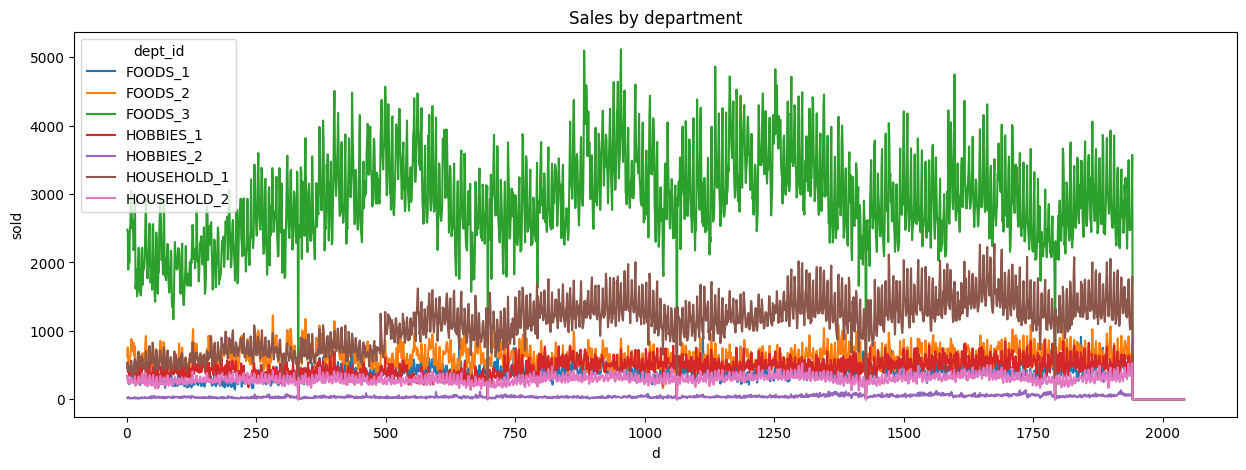

In [ ]:
sales_department=df.groupby(["dept_id","d"])["sold"].sum().reset_index()
plt.figure(figsize=(15,5))
sns.lineplot(data=sales_department, x="d", y="sold", hue="dept_id")
plt.title("Sales by department")
plt.show()

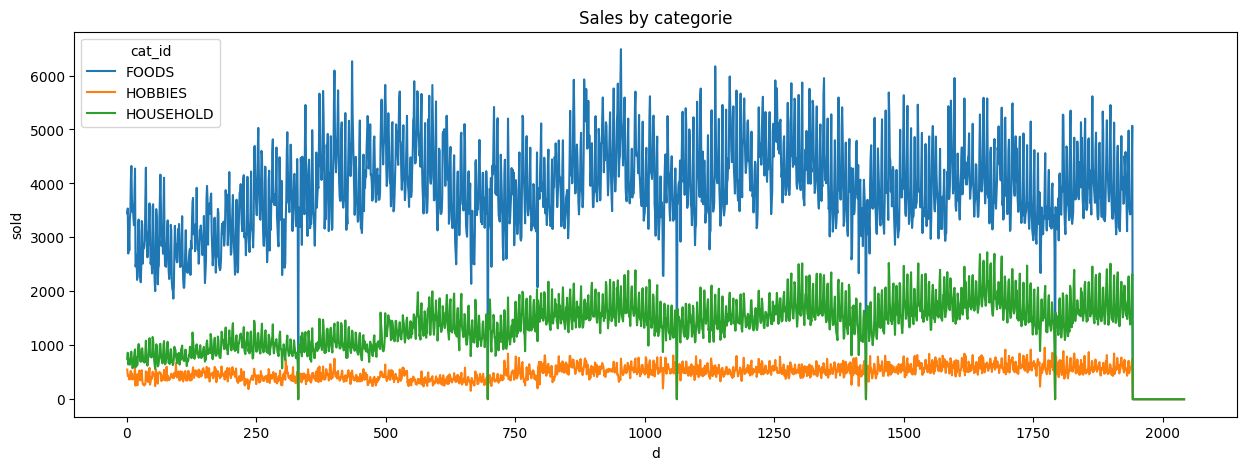

In [ ]:
sales_department=df.groupby(["cat_id","d"])["sold"].sum().reset_index()
plt.figure(figsize=(15,5))
sns.lineplot(data=sales_department, x="d", y="sold", hue="cat_id")
plt.title("Sales by categorie")
plt.show()

## FEATURE ENGINEERING

### LABEL ENCODING

In [ ]:
df.head()

,item_id,dept_id,cat_id,d,sold,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,1,0,2011-01-29,11104.0,Saturday,1.0,1.0,2011.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,8.265625
1,HOBBIES_1_002,HOBBIES_1,HOBBIES,1,0,2011-01-29,11104.0,Saturday,1.0,1.0,2011.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,3.949219
2,HOBBIES_1_003,HOBBIES_1,HOBBIES,1,0,2011-01-29,11104.0,Saturday,1.0,1.0,2011.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,2.970703
3,HOBBIES_1_004,HOBBIES_1,HOBBIES,1,0,2011-01-29,11104.0,Saturday,1.0,1.0,2011.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,4.527344
4,HOBBIES_1_005,HOBBIES_1,HOBBIES,1,0,2011-01-29,11104.0,Saturday,1.0,1.0,2011.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,2.941406


We are going to do numerical the categorycal columns

We save dictionarys to future changes

In [ ]:
d_item_id = dict(zip(df.item_id.cat.codes, df.item_id))
d_dept_id = dict(zip(df.dept_id.cat.codes, df.dept_id))
d_cat_id = dict(zip(df.cat_id.cat.codes, df.cat_id))

df_item_id = pd.DataFrame(list(d_item_id.items()), columns=['item_code', 'item_id'])
df_dept_id = pd.DataFrame(list(d_dept_id.items()), columns=['dept_code', 'dept_id'])
df_cat_id = pd.DataFrame(list(d_cat_id.items()), columns=['cat_code', 'cat_id'])

df_item_id.to_csv('/content/drive/MyDrive/ordenador/TEORÍA+PROYECTOS/m5-forecasting-accuracy/datadiccionario_item_id.csv', index=False)
df_dept_id.to_csv('/content/drive/MyDrive/ordenador/TEORÍA+PROYECTOS/m5-forecasting-accuracy/datadiccionario_dept_id.csv', index=False)
df_cat_id.to_csv('/content/drive/MyDrive/ordenador/TEORÍA+PROYECTOS/m5-forecasting-accuracy/datadiccionario_cat_id.csv', index=False)

In [ ]:
cols = df.dtypes.index.tolist()
types = df.dtypes.values.tolist()

for i, type in enumerate(types):
    if type.name == 'category':   # if column datatype is category, we change their valors for their category code.
        df[cols[i]] = df[cols[i]].cat.codes

In [ ]:
df.head()

,item_id,dept_id,cat_id,d,sold,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,1437,3,1,1,0,2011-01-29,11104.0,2,1.0,1.0,2011.0,-1,-1,-1,-1,0.0,0.0,0.0,8.265625
1,1438,3,1,1,0,2011-01-29,11104.0,2,1.0,1.0,2011.0,-1,-1,-1,-1,0.0,0.0,0.0,3.949219
2,1439,3,1,1,0,2011-01-29,11104.0,2,1.0,1.0,2011.0,-1,-1,-1,-1,0.0,0.0,0.0,2.970703
3,1440,3,1,1,0,2011-01-29,11104.0,2,1.0,1.0,2011.0,-1,-1,-1,-1,0.0,0.0,0.0,4.527344
4,1441,3,1,1,0,2011-01-29,11104.0,2,1.0,1.0,2011.0,-1,-1,-1,-1,0.0,0.0,0.0,2.941406


### MEAN ENCODING.

Now, we are going to create new features based on the mean of a the targets.

In [ ]:
df['item_sold_avg'] = df.groupby('item_id')['sold'].transform('mean').astype(np.float16)

df['cat_sold_avg'] = df.groupby('cat_id')['sold'].transform('mean').astype(np.float16)

df['dept_sold_avg'] = df.groupby('dept_id')['sold'].transform('mean').astype(np.float16)

df['cat_dept_sold_avg'] = df.groupby(['cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)

In [ ]:
df.head()

,item_id,dept_id,cat_id,d,sold,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,item_sold_avg,cat_sold_avg,dept_sold_avg,cat_dept_sold_avg
0,1437,3,1,1,0,2011-01-29,11104.0,2,1.0,1.0,2011.0,-1,-1,-1,-1,0.0,0.0,0.0,8.265625,0.385986,0.847656,1.060547,1.060547
1,1438,3,1,1,0,2011-01-29,11104.0,2,1.0,1.0,2011.0,-1,-1,-1,-1,0.0,0.0,0.0,3.949219,0.221924,0.847656,1.060547,1.060547
2,1439,3,1,1,0,2011-01-29,11104.0,2,1.0,1.0,2011.0,-1,-1,-1,-1,0.0,0.0,0.0,2.970703,0.069580,0.847656,1.060547,1.060547
3,1440,3,1,1,0,2011-01-29,11104.0,2,1.0,1.0,2011.0,-1,-1,-1,-1,0.0,0.0,0.0,4.527344,5.183594,0.847656,1.060547,1.060547
4,1441,3,1,1,0,2011-01-29,11104.0,2,1.0,1.0,2011.0,-1,-1,-1,-1,0.0,0.0,0.0,2.941406,1.330078,0.847656,1.060547,1.060547


### ADDING LAG OF A FEW DAYS

In [ ]:
lags = [1,2,3,4,5,6,7,10,12,15]
for lag in lags:
    df['sold_lag_'+str(lag)] = df.groupby(['item_id'],as_index=False)['sold'].shift(lag).astype(np.float16)

### WINDOWS STATISTICS AND EXPANDING WINDOW STATISTICS

We are going to use rolling windows statistics with 7, 14 and 30 days.

And adding expanding windows median too.

In [ ]:
df['rolling_sold_mean'] = df.groupby(['item_id', 'dept_id', 'cat_id'])['sold'].transform(lambda x: x.rolling(window=7).mean()).astype(np.float16)
df['rolling_sold_mean_14'] = df.groupby(['item_id', 'dept_id', 'cat_id'])['sold'].transform(lambda x: x.rolling(window=7).mean()).astype(np.float16)
df['rolling_sold_mean_28'] = df.groupby(['item_id', 'dept_id', 'cat_id'])['sold'].transform(lambda x: x.rolling(window=7).mean()).astype(np.float16)

In [ ]:
df['expanding_sold_mean'] = df.groupby(['item_id', 'dept_id', 'cat_id'])['sold'].transform(lambda x: x.expanding(2).mean()).astype(np.float16)

### DELETING nan because of the lags

In [ ]:
df=df[df["d"]>15]

In [ ]:
df.head()

In [ ]:
df.tail()

In [ ]:
df.to_pickle('/content/drive/MyDrive/ordenador/TEORÍA+PROYECTOS/m5-forecasting-accuracy/data/data.pkl')

# TRAIN-VALIDATION-TEST

In [ ]:
df=pd.read_pickle('/content/drive/MyDrive/ordenador/TEORÍA+PROYECTOS/m5-forecasting-accuracy/data/data.pkl')

In [ ]:
df=df[df["d"]<1970]

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
df.head()

,item_id,dept_id,cat_id,d,sold,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,item_sold_avg,cat_sold_avg,dept_sold_avg,cat_dept_sold_avg,sold_lag_1,sold_lag_2,sold_lag_3,sold_lag_4,sold_lag_5,sold_lag_6,sold_lag_7,sold_lag_10,sold_lag_12,sold_lag_15,rolling_sold_mean,rolling_sold_mean_14,rolling_sold_mean_28,expanding_sold_mean
45735,1437,3,1,16,0,2011-02-13,11104.0,3,2.0,2.0,2011.0,-1,-1,-1,-1,0.0,1.0,0.0,8.265625,0.385986,0.847656,1.060547,1.060547,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00
45736,1438,3,1,16,0,2011-02-13,11104.0,3,2.0,2.0,2011.0,-1,-1,-1,-1,0.0,1.0,0.0,3.949219,0.221924,0.847656,1.060547,1.060547,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00
45737,1439,3,1,16,0,2011-02-13,11104.0,3,2.0,2.0,2011.0,-1,-1,-1,-1,0.0,1.0,0.0,2.970703,0.069580,0.847656,1.060547,1.060547,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00
45738,1440,3,1,16,0,2011-02-13,11104.0,3,2.0,2.0,2011.0,-1,-1,-1,-1,0.0,1.0,0.0,4.339844,5.183594,0.847656,1.060547,1.060547,0.0,2.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.713867,1.713867,1.713867,0.75
45739,1441,3,1,16,0,2011-02-13,11104.0,3,2.0,2.0,2011.0,-1,-1,-1,-1,0.0,1.0,0.0,2.941406,1.330078,0.847656,1.060547,1.060547,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00


In [ ]:
test_start_day = 1942
test_end_day = 1969
val_start_day = 1914
val_end_day = 1941

In [ ]:
# Separar el conjunto de validation
df_val = df[(df['d'] >=1914 ) & (df['d'] <= 1941)]


df_test = df[(df['d'] >=1942 ) & (df['d'] <= 1969)]

# Separar el conjunto de entrenamiento (todos los días antes del conjunto de prueba)
df_train = df[df['d'] < 1914 ]

In [ ]:
df_train.to_pickle("/content/drive/MyDrive/ordenador/TEORÍA+PROYECTOS/m5-forecasting-accuracy/data/train.pkl")

df_test.to_pickle("/content/drive/MyDrive/ordenador/TEORÍA+PROYECTOS/m5-forecasting-accuracy/data/test.pkl")

df_val.to_pickle("/content/drive/MyDrive/ordenador/TEORÍA+PROYECTOS/m5-forecasting-accuracy/data/validation.pkl")

# FIRST MODELING

Por la naturaleza de nuestro problema y viendo como están los datos, los modelos que seguramente mejor funcionen serán xgboost, light lbm y lstm.

LIGHT LBM Y XGBOOST Ambos modelos son variantes de Gradient Boosting y pueden manejar datos con muchas variables explicativas (features). Además son efectivos con features de lag y estadísticas de ventanas, y suelen ser robustos a datos ruidosos.



LSTM: Ideal para series temporales con dependencias largas y no lineales. Funciona bien cuando las features incluyen lags y ventanas.









DESPUÉS DE LAS PRUEBAS QUE HEMOS LLEVADO A CABO, TENEMOS DOS OPCIONES LAS CUALES PARECEN VIABLES. EN PRIMER LUGAR, TENEMOS XGBOOST QUE SE ADAPTA BIEN Y CONSGUIMOS BUENAS MÉTRICAS. POR OTRO LADO, TENEMOS LSTM, QUE CONSIGUE ALGUNAS MÉTRICAS MEJORES Y OTRAS PEORES, PERO QUE A LA HORA DE GENERALIZAR PARECE QUE SE ADAPTA MEJOR. POR LO QUE VAMOS A PONER VARIAS CONCLUSIONES.

**-MÉTRICAS:** AMBAS MÉTRICAS SON BUENAS Y PARECIDAS. POR LO QUE NO VAN A SER UN FACTOR DETERMINANTE.


**-LSTM:** NOS GUSTA MAS LA GENERALIZACIÓN QUE HACE DE LOS DATOS EN EL SET DE TEST. PROBLEMA: REQUIERE UN ALTO COSTE COMPUTACIONAL. TARDAMOS MUCHO TIEMPO EN ENTRENAR ESTE MODELO, POR LO QUE PUEDE SER UN GRAN TRABAJO LA OPTIMIZACIÓN, AUNQUE CON LSTM, NO SEA NECESARIO UN GRAN TRABAJO DE ESTRUCTURA.



**- XGBOOST:** NOS GUSTA MENOS COMO GENERALIZA, PERO EL COSTE COMPUTACIONAL ES MUCHO MÁS BAJO. POR LO QUE VALE LA PENA INTENTAR OPTIMIZARLO EN UN PRIMER LUGAR.

In [ ]:
df_train = pd.read_pickle("/content/drive/MyDrive/ordenador/TEORÍA+PROYECTOS/m5-forecasting-accuracy/data/train.pkl")
df_test = pd.read_pickle("/content/drive/MyDrive/ordenador/TEORÍA+PROYECTOS/m5-forecasting-accuracy/data/test.pkl")
df_val = pd.read_pickle("/content/drive/MyDrive/ordenador/TEORÍA+PROYECTOS/m5-forecasting-accuracy/data/validation.pkl")

In [ ]:
df_train.head()

,item_id,dept_id,cat_id,d,sold,date,wm_yr_wk,weekday,wday,month,...,sold_lag_5,sold_lag_6,sold_lag_7,sold_lag_10,sold_lag_12,sold_lag_15,rolling_sold_mean,rolling_sold_mean_14,rolling_sold_mean_28,expanding_sold_mean
45735,1437,3,1,16,0,2011-02-13,11104.0,3,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00
45736,1438,3,1,16,0,2011-02-13,11104.0,3,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00
45737,1439,3,1,16,0,2011-02-13,11104.0,3,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00
45738,1440,3,1,16,0,2011-02-13,11104.0,3,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.713867,1.713867,1.713867,0.75
45739,1441,3,1,16,0,2011-02-13,11104.0,3,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00


we are not going to use date column, so we can drop it.

In [ ]:
df_train.drop(["date"], axis=1, inplace=True)
df_test.drop(["date"], axis=1, inplace=True)
df_val.drop(["date"], axis=1, inplace=True)

In [ ]:
X_train, y_train = df_train.drop(columns=['sold']), df_train['sold']
X_val, y_val = df_val.drop(columns=['sold']), df_val['sold']

In [ ]:
df_train.head()

,item_id,dept_id,cat_id,d,sold,wm_yr_wk,weekday,wday,month,year,...,sold_lag_5,sold_lag_6,sold_lag_7,sold_lag_10,sold_lag_12,sold_lag_15,rolling_sold_mean,rolling_sold_mean_14,rolling_sold_mean_28,expanding_sold_mean
45735,1437,3,1,16,0,11104.0,3,2.0,2.0,2011.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00
45736,1438,3,1,16,0,11104.0,3,2.0,2.0,2011.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00
45737,1439,3,1,16,0,11104.0,3,2.0,2.0,2011.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00
45738,1440,3,1,16,0,11104.0,3,2.0,2.0,2011.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.713867,1.713867,1.713867,0.75
45739,1441,3,1,16,0,11104.0,3,2.0,2.0,2011.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00


## XGBOOST

### TRAIN

In [ ]:
# Configuración del modelo XGBoost
xgb_model = XGBRegressor(
    objective='reg:squarederror' # Tipo de error cuadrado para regresión
         # Porcentaje de características por árbol
)

# Entrenar el modelo
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Guardar el modelo en un archivo .json (formato de XGBoost)
xgb_model.save_model('/content/drive/MyDrive/ordenador/TEORÍA+PROYECTOS/m5-forecasting-accuracy/models/xgb_model.json')

### VALIDATION

In [ ]:
df_val = pd.read_pickle("/content/drive/MyDrive/ordenador/TEORÍA+PROYECTOS/m5-forecasting-accuracy/data/validation.pkl")
df_val.drop(["date"], axis=1, inplace=True)

In [ ]:
X_val, y_val = df_val.drop(columns=['sold']), df_val['sold']

In [ ]:
xgb_model = XGBRegressor()
xgb_model.load_model('/content/drive/MyDrive/ordenador/TEORÍA+PROYECTOS/m5-forecasting-accuracy/models/xgb_model.json')

In [ ]:
y_pred_val = xgb_model.predict(X_val)

In [ ]:
df_val["pred_sales"] = y_pred_val

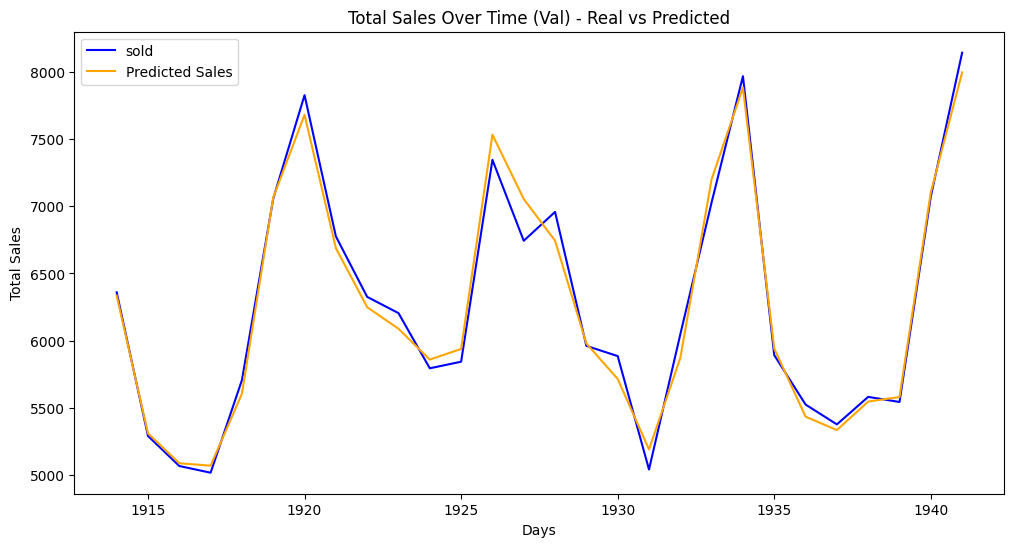

In [ ]:
sum_sales_by_day_val = df_val.groupby('d')[['sold', 'pred_sales']].sum()

# Gráfica de la sumatoria de ventas diaria (Predicciones vs Reales) en el conjunto de validación
plt.figure(figsize=(12, 6))
plt.plot(sum_sales_by_day_val.index, sum_sales_by_day_val['sold'], label='sold', color='blue')
plt.plot(sum_sales_by_day_val.index, sum_sales_by_day_val['pred_sales'], label='Predicted Sales', color='orange')
plt.xlabel('Days')
plt.ylabel('Total Sales')
plt.title('Total Sales Over Time (Val) - Real vs Predicted')
plt.legend()
plt.show()

In [ ]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

# Función para RMSSE (Métrica personalizada para series temporales)
def rmsse(y_true, y_pred):
    naive_error = y_true.diff().dropna() ** 2
    scaled_error = ((y_true - y_pred) ** 2).sum() / naive_error.sum()
    return (scaled_error ** 0.5)


def accuracy_within_threshold(y_true, y_pred, threshold=0.2):
    within_threshold = abs(y_true - y_pred) <= threshold * y_true
    return within_threshold.mean() * 100  # Porcentaje de aciertos dentro del umbral

# Evaluación en el conjunto de prueba
rmse_test = rmse(y_val, y_pred_val)
mae_test = mean_absolute_error(y_val, y_pred_val)
rmsse_test = rmsse(y_val, y_pred_val)
accuracy_test = accuracy_within_threshold(y_val, y_pred_val)



# Resultados
print(f"RMSE - Test: {rmse_test:.4f}")
print(f"MAE - Test: {mae_test:.4f}")
print(f"RMSSE - Test: {rmsse_test:.4f}")
print(f"Accuracy  - Test: {accuracy_test:.2f}%")

RMSE - Test: 1.1248
MAE - Test: 0.4439
RMSSE - Test: 0.1709
Accuracy  - Test: 33.95%


### FEATURE IMPORTANCE

<Figure size 1000x600 with 0 Axes>

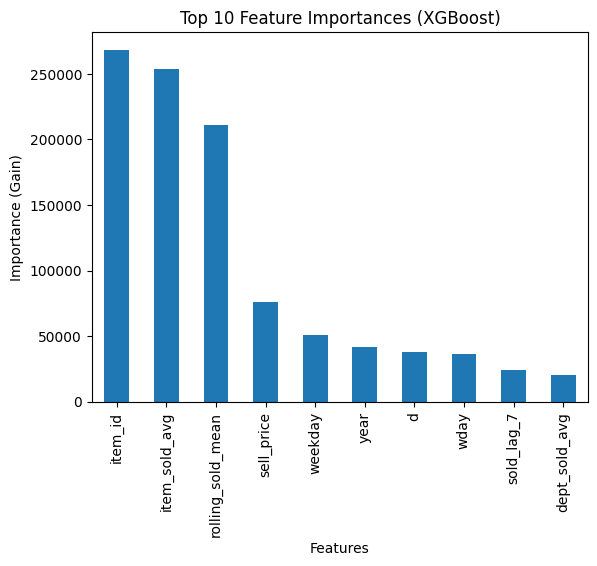

In [ ]:
# Obtener la importancia de las características del modelo XGBoost
feature_importance = xgb_model.get_booster().get_score(importance_type='gain')

# Convertir la importancia de las características a un DataFrame
feature_importance_df = pd.DataFrame.from_dict(feature_importance, orient='index', columns=['importance'])
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Gráfica de la importancia de las características
plt.figure(figsize=(10, 6))
feature_importance_df.head(10).plot(kind='bar', legend=None)
plt.title('Top 10 Feature Importances (XGBoost)')
plt.xlabel('Features')
plt.ylabel('Importance (Gain)')
plt.show()

### TEST

In [ ]:
df_test = pd.read_pickle("/content/drive/MyDrive/ordenador/TEORÍA+PROYECTOS/m5-forecasting-accuracy/data/test.pkl")
df_test.drop(["date"], axis=1, inplace=True)

df_val = pd.read_pickle("/content/drive/MyDrive/ordenador/TEORÍA+PROYECTOS/m5-forecasting-accuracy/data/validation.pkl")
df_val.drop(["date"], axis=1, inplace=True)

In [ ]:
df_combined = pd.concat([df_val, df_test], ignore_index=True)

df_combined = df_combined.sort_values(by='d', ascending=True)

In [ ]:
df_predictions= predictions(df_combined, 28, xgb_model)

In [ ]:
df_predictions.tail()

,item_id,dept_id,cat_id,d,sold,wm_yr_wk,weekday,wday,month,year,...,sold_lag_5,sold_lag_6,sold_lag_7,sold_lag_10,sold_lag_12,sold_lag_15,rolling_sold_mean,rolling_sold_mean_14,rolling_sold_mean_28,expanding_sold_mean
168714,2456,5,2,1969,0.002156,11624.0,3,2.0,6.0,2016.0,...,0.009102,0.009102,0.002155,0.009102,0.009102,0.002155,0.006809,0.006962,0.025558,0.026276
168715,2457,5,2,1969,0.002156,11624.0,3,2.0,6.0,2016.0,...,0.009102,0.009102,0.002155,0.143433,0.116211,1.000000,0.006809,0.069275,0.822754,1.070312
168716,2458,5,2,1969,0.002156,11624.0,3,2.0,6.0,2016.0,...,0.009102,0.009102,0.002155,0.009102,0.009102,0.002155,0.006809,0.006962,0.007038,0.006870
168707,2449,5,2,1969,0.002156,11624.0,3,2.0,6.0,2016.0,...,0.088806,0.084351,0.161255,0.212158,0.132324,0.179932,0.028946,0.159546,0.372314,0.462891
170743,1436,2,0,1969,0.002156,11624.0,3,2.0,6.0,2016.0,...,0.009102,0.009102,0.002155,0.009102,0.009102,0.161621,0.006809,0.012657,0.254639,0.314697


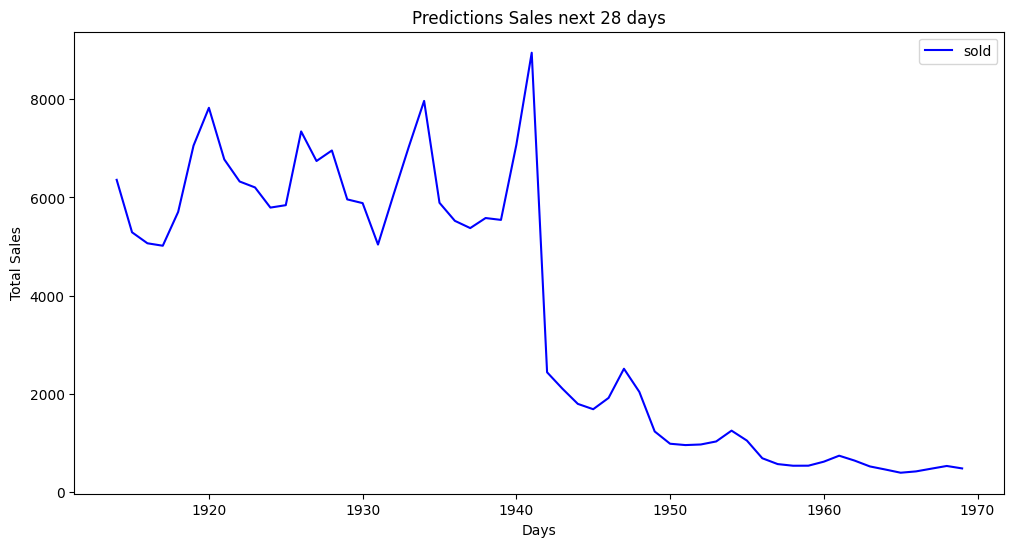

In [ ]:
# Calcular la sumatoria diaria de ventas (predicciones y reales) en el conjunto de validación
sum_sales_by_day_predictions = df_predictions.groupby('d')[["sold"]].sum()

# Gráfica de la sumatoria de ventas diaria (Predicciones vs Reales) en el conjunto de validación
plt.figure(figsize=(12, 6))
plt.plot(sum_sales_by_day_predictions.index, sum_sales_by_day_predictions['sold'], label='sold', color='blue')
plt.xlabel('Days')
plt.ylabel('Total Sales')
plt.title('Predictions Sales next 28 days')
plt.legend()
plt.show()

## LIGHT LBM

### TRAIN

In [ ]:
# Configuración inicial del modelo LightGBM
lgb_model = lgb.LGBMRegressor(
    objective='regression'#,   # Función objetivo para regresión
 #   n_estimators=500,         # Número de árboles (ajustable)
 #   learning_rate=0.1,        # Tasa de aprendizaje
 #   max_depth=8,              # Profundidad máxima de los árboles
 #   subsample=0.8,            # Porcentaje de muestras por árbol
 #   colsample_bytree=0.8,     # Porcentaje de características por árbol
 #   n_jobs=-1,                # Utilizar todos los núcleos disponibles
 #   random_state=42           # Semilla para reproducibilidad
)

# Entrenar el modelo
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.970552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3389
[LightGBM] [Info] Number of data points in the train set: 5787002, number of used features: 35
[LightGBM] [Info] Start training from score 1.921339


LGBMRegressor(objective='regression')

In [ ]:
# Guarda el modelo
dump(lgb_model, '/content/drive/MyDrive/ordenador/TEORÍA+PROYECTOS/m5-forecasting-accuracy/models/lgb_model.joblib')

['/content/drive/MyDrive/ordenador/TEORÍA+PROYECTOS/m5-forecasting-accuracy/models/lgb_model.joblib']

### VALIDATION

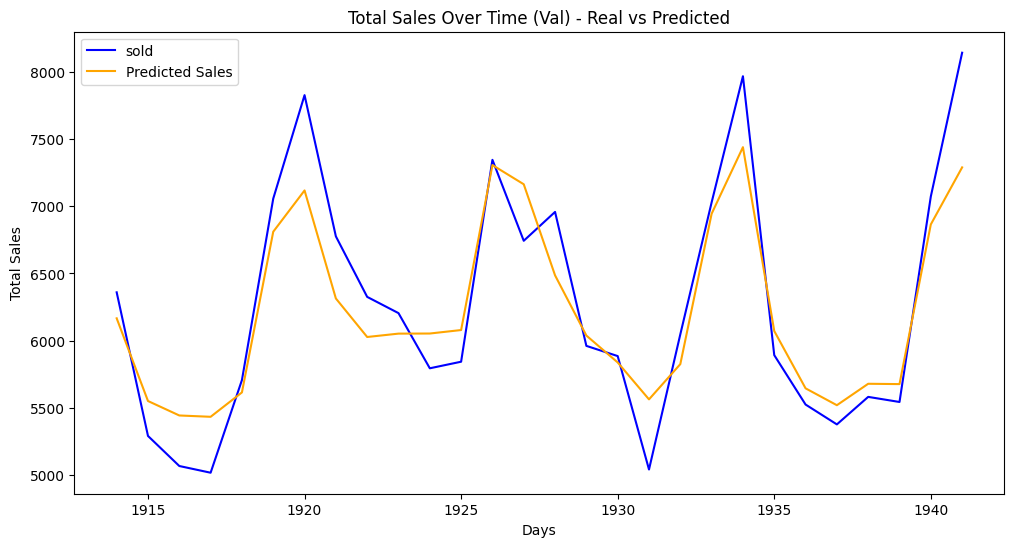

In [ ]:
df_val = pd.read_pickle("/content/drive/MyDrive/ordenador/TEORÍA+PROYECTOS/m5-forecasting-accuracy/data/validation.pkl")
df_val.drop(["date"], axis=1, inplace=True)

X_val, y_val = df_val.drop(columns=['sold']), df_val['sold']

###### SELECCIÓN DEL MODELO
lgb_model = load('/content/drive/MyDrive/ordenador/TEORÍA+PROYECTOS/m5-forecasting-accuracy/models/lgb_model.joblib')

y_pred_val = lgb_model.predict(X_val)

##### FIN SELECCIÓN DEL MODELO

df_val["pred_sales"] = y_pred_val


# Gráfica de la sumatoria de ventas diaria (Predicciones vs Reales) en el conjunto de validación
sum_sales_by_day_val = df_val.groupby('d')[['sold', 'pred_sales']].sum()
plt.figure(figsize=(12, 6))
plt.plot(sum_sales_by_day_val.index, sum_sales_by_day_val['sold'], label='sold', color='blue')
plt.plot(sum_sales_by_day_val.index, sum_sales_by_day_val['pred_sales'], label='Predicted Sales', color='orange')
plt.xlabel('Days')
plt.ylabel('Total Sales')
plt.title('Total Sales Over Time (Val) - Real vs Predicted')
plt.legend()
plt.show()

In [ ]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

# Función para RMSSE (Métrica personalizada para series temporales)
def rmsse(y_true, y_pred):
    naive_error = y_true.diff().dropna() ** 2
    scaled_error = ((y_true - y_pred) ** 2).sum() / naive_error.sum()
    return (scaled_error ** 0.5)


def accuracy_within_threshold(y_true, y_pred, threshold=0.2):
    within_threshold = abs(y_true - y_pred) <= threshold * y_true
    return within_threshold.mean() * 100  # Porcentaje de aciertos dentro del umbral

# Evaluación en el conjunto de prueba
rmse_test = rmse(y_val, y_pred_val)
mae_test = mean_absolute_error(y_val, y_pred_val)
rmsse_test = rmsse(y_val, y_pred_val)
accuracy_test = accuracy_within_threshold(y_val, y_pred_val)



# Resultados
print(f"RMSE - Test: {rmse_test:.4f}")
print(f"MAE - Test: {mae_test:.4f}")
print(f"RMSSE - Test: {rmsse_test:.4f}")
print(f"Accuracy  - Test: {accuracy_test:.2f}%")

RMSE - Test: 1.6040
MAE - Test: 0.9014
RMSSE - Test: 0.2437
Accuracy  - Test: 15.62%


### FEATURE IMPORTANCE

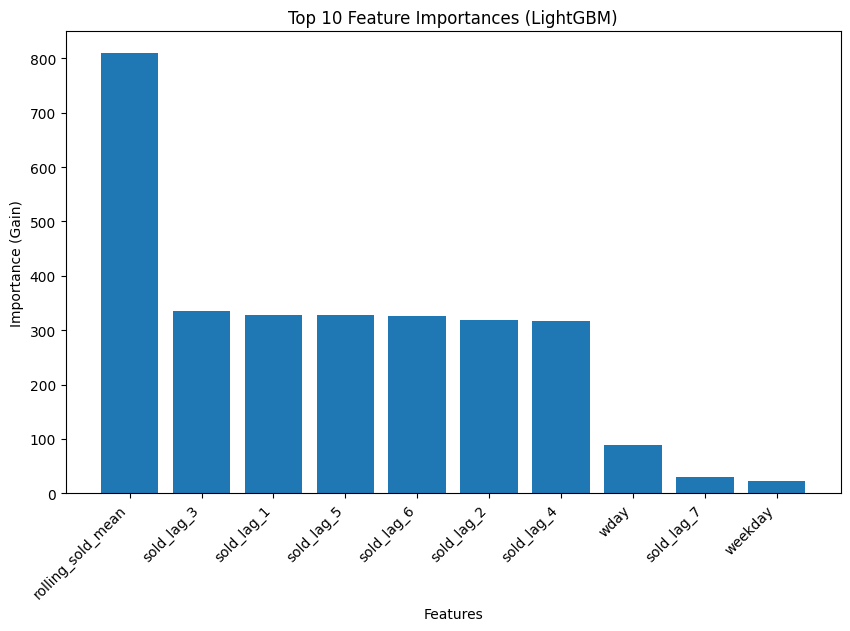

In [ ]:
# Obtener la importancia de las características
feature_importance = lgb_model.feature_importances_

# Convertir la importancia de las características a un DataFrame
feature_importance_df = pd.DataFrame({
    'feature': lgb_model.feature_name_,
    'importance': feature_importance
}).sort_values(by='importance', ascending=False)



# Gráfica de la importancia de las características
plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['feature'].head(10), feature_importance_df['importance'].head(10))
plt.title('Top 10 Feature Importances (LightGBM)')
plt.xlabel('Features')
plt.ylabel('Importance (Gain)')
plt.xticks(rotation=45, ha='right')  # Rota los nombres para que sean más legibles
plt.show()

### TEST

In [ ]:
df_test = pd.read_pickle("/content/drive/MyDrive/ordenador/TEORÍA+PROYECTOS/m5-forecasting-accuracy/data/test.pkl")
df_test.drop(["date"], axis=1, inplace=True)

df_val = pd.read_pickle("/content/drive/MyDrive/ordenador/TEORÍA+PROYECTOS/m5-forecasting-accuracy/data/validation.pkl")
df_val.drop(["date"], axis=1, inplace=True)

df_combined = pd.concat([df_val, df_test], ignore_index=True)

df_combined = df_combined.sort_values(by='d', ascending=True)

In [ ]:
df_predictions= predictions(df_combined, 28, lgb_model)

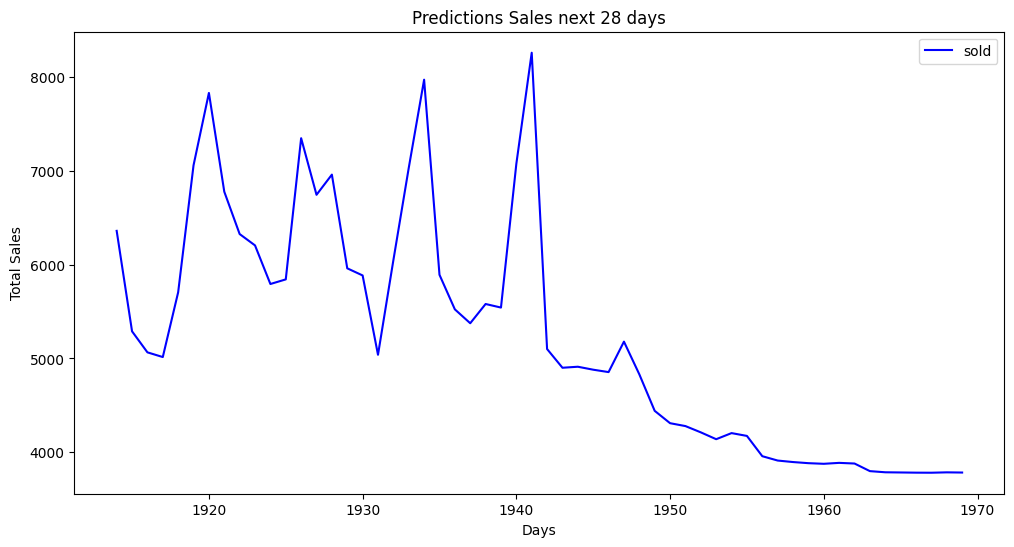

In [ ]:
# Calcular la sumatoria diaria de ventas (predicciones y reales) en el conjunto de validación
sum_sales_by_day_predictions = df_predictions.groupby('d')[["sold"]].sum()

# Gráfica de la sumatoria de ventas diaria (Predicciones vs Reales) en el conjunto de validación
plt.figure(figsize=(12, 6))
plt.plot(sum_sales_by_day_predictions.index, sum_sales_by_day_predictions['sold'], label='sold', color='blue')
plt.xlabel('Days')
plt.ylabel('Total Sales')
plt.title('Predictions Sales next 28 days')
plt.legend()
plt.show()

## LSTM

In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)


### ENTRENAMIENTO

return_sequences=True en la primera capa LSTM: Esto permite que la primera capa LSTM devuelva una secuencia completa (con dimensión 3D), que es el formato esperado por la segunda capa LSTM.

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(X_train_scaled.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

start_time = time.time()
model.fit(X_train_scaled, y_train, epochs=20, batch_size=128, callbacks=[early_stopping])
end_time = time.time()

training_time = end_time - start_time

Epoch 1/20
45211/45211 ━━━━━━━━━━━━━━━━━━━━ 254s 6ms/step - loss: 26.9591
Epoch 2/20
45211/45211 ━━━━━━━━━━━━━━━━━━━━ 263s 6ms/step - loss: 889950.8125
Epoch 3/20
45211/45211 ━━━━━━━━━━━━━━━━━━━━ 265s 6ms/step - loss: 35066880000.0000
Epoch 4/20
45211/45211 ━━━━━━━━━━━━━━━━━━━━ 261s 6ms/step - loss: 24507.5234
Epoch 5/20
45211/45211 ━━━━━━━━━━━━━━━━━━━━ 253s 6ms/step - loss: 17.5019
Epoch 6/20
45211/45211 ━━━━━━━━━━━━━━━━━━━━ 254s 6ms/step - loss: 8781.6514
Epoch 7/20
45211/45211 ━━━━━━━━━━━━━━━━━━━━ 264s 6ms/step - loss: 16.1811
Epoch 8/20
45211/45211 ━━━━━━━━━━━━━━━━━━━━ 261s 6ms/step - loss: 8.3661
Epoch 9/20
45211/45211 ━━━━━━━━━━━━━━━━━━━━ 254s 6ms/step - loss: 121.7428
Epoch 10/20
45211/45211 ━━━━━━━━━━━━━━━━━━━━ 260s 6ms/step - loss: 5.5529
Epoch 11/20
45211/45211 ━━━━━━━━━━━━━━━━━━━━ 260s 6ms/step - loss: 2.9191
Epoch 12/20
45211/45211 ━━━━━━━━━━━━━━━━━━━━ 251s 6ms/step - loss: 9.2434
Epoch 13/20
45211/45211 ━━━━━━━━━━━━━━━━━━━━ 250s 6ms/step - loss: 661.1859
Epoch 14/20
45211/

In [ ]:
print(f"Tiempo de entrenamiento: {training_time // 60:.0f} minutos y {training_time % 60:.2f} segundos")

Tiempo de entrenamiento: 88 minutos y 12.80 segundos


In [ ]:
keras.saving.save_model(filepath='/content/drive/MyDrive/ordenador/TEORÍA+PROYECTOS/m5-forecasting-accuracy/models/model_lstm.keras',model=model)

### Validation

2668/2668 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


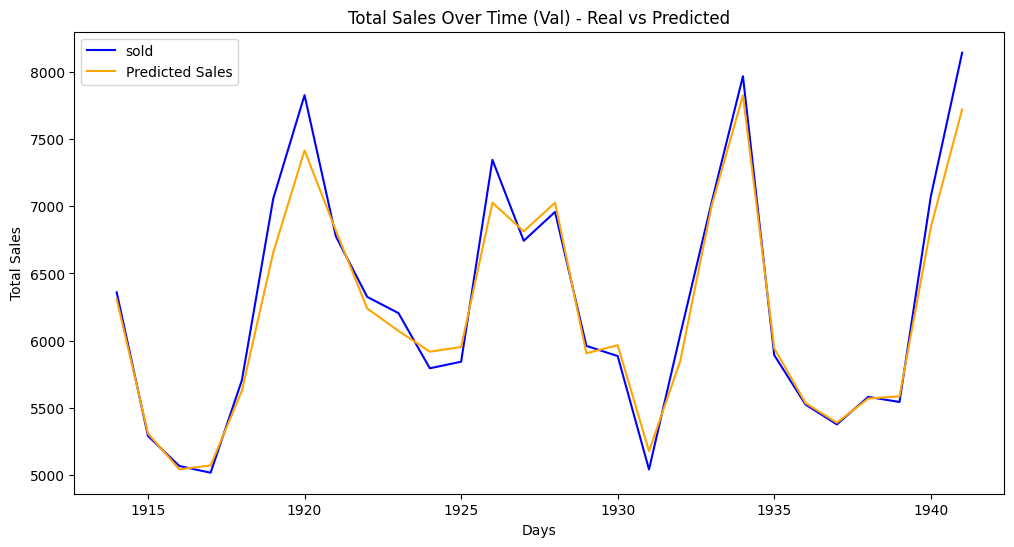

In [ ]:
df_val = pd.read_pickle("/content/drive/MyDrive/ordenador/TEORÍA+PROYECTOS/m5-forecasting-accuracy/data/validation.pkl")
df_val.drop(["date"], axis=1, inplace=True)

X_val, y_val = df_val.drop(columns=['sold']), df_val['sold']



###### SELECCIÓN DEL MODELO
lstm_model = load_model('/content/drive/MyDrive/ordenador/TEORÍA+PROYECTOS/m5-forecasting-accuracy/models/model_lstm.keras')

X_val_scaled = scaler.transform(X_val)

y_pred_val = lstm_model.predict(X_val_scaled)

##### FIN SELECCIÓN DEL MODELO

df_val["pred_sales"] = y_pred_val


# Gráfica de la sumatoria de ventas diaria (Predicciones vs Reales) en el conjunto de validación
sum_sales_by_day_val = df_val.groupby('d')[['sold', 'pred_sales']].sum()
plt.figure(figsize=(12, 6))
plt.plot(sum_sales_by_day_val.index, sum_sales_by_day_val['sold'], label='sold', color='blue')
plt.plot(sum_sales_by_day_val.index, sum_sales_by_day_val['pred_sales'], label='Predicted Sales', color='orange')
plt.xlabel('Days')
plt.ylabel('Total Sales')
plt.title('Total Sales Over Time (Val) - Real vs Predicted')
plt.legend()
plt.show()

In [ ]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

# Función para RMSSE (Métrica personalizada para series temporales)
def rmsse(y_true, y_pred):
    naive_error = y_true.diff().dropna() ** 2
    scaled_error = ((y_true - y_pred) ** 2).sum() / naive_error.sum()
    return (scaled_error ** 0.5)


def accuracy_within_threshold(y_true, y_pred, threshold=0.2):
    within_threshold = abs(y_true - y_pred) <= threshold * y_true
    return within_threshold.mean() * 100  # Porcentaje de aciertos dentro del umbral

y_pred_val = y_pred_val.flatten()
# Evaluación en el conjunto de prueba
rmse_test = rmse(y_val, y_pred_val)
mae_test = mean_absolute_error(y_val, y_pred_val)
rmsse_test = rmsse(y_val, y_pred_val)
accuracy_test = accuracy_within_threshold(y_val, y_pred_val)



# Resultados
print(f"RMSE - Test: {rmse_test:.4f}")
print(f"MAE - Test: {mae_test:.4f}")
print(f"RMSSE - Test: {rmsse_test:.4f}")
print(f"Accuracy  - Test: {accuracy_test:.2f}%")

RMSE - Test: 0.5999
MAE - Test: 0.3711
RMSSE - Test: 0.0911
Accuracy  - Test: 32.80%


### TEST

In [ ]:
df_test = pd.read_pickle("/content/drive/MyDrive/ordenador/TEORÍA+PROYECTOS/m5-forecasting-accuracy/data/test.pkl")
df_test.drop(["date"], axis=1, inplace=True)

df_val = pd.read_pickle("/content/drive/MyDrive/ordenador/TEORÍA+PROYECTOS/m5-forecasting-accuracy/data/validation.pkl")
df_val.drop(["date"], axis=1, inplace=True)

df_combined = pd.concat([df_val, df_test], ignore_index=True)

df_combined = df_combined.sort_values(by='d', ascending=True)

In [ ]:
df_predictions= predictions_lstm(df_combined, 28, lstm_model)

96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
96/96 ━━━━━━━━━━━━━━━━━━━

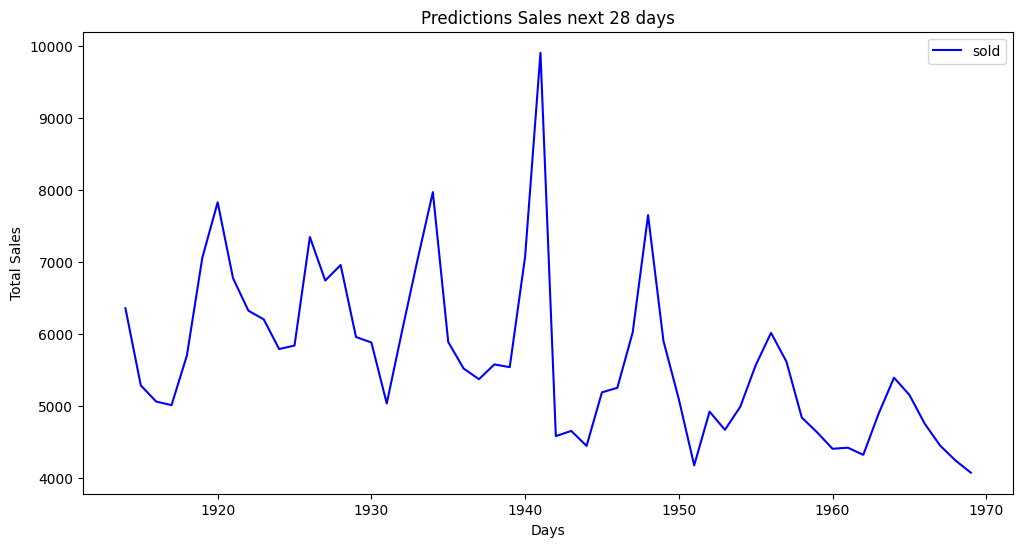

In [ ]:
# Calcular la sumatoria diaria de ventas (predicciones y reales) en el conjunto de validación
sum_sales_by_day_predictions = df_predictions.groupby('d')[["sold"]].sum()

# Gráfica de la sumatoria de ventas diaria (Predicciones vs Reales) en el conjunto de validación
plt.figure(figsize=(12, 6))
plt.plot(sum_sales_by_day_predictions.index, sum_sales_by_day_predictions['sold'], label='sold', color='blue')
plt.xlabel('Days')
plt.ylabel('Total Sales')
plt.title('Predictions Sales next 28 days')
plt.legend()
plt.show()